In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Pi = np.pi

The first example of a fractal we will run into is the Weierstrass function which is given by
$$
f(x;a,b) = \sum_{k=0}^{\infty} a^{k}\cos(b^{k}\pi x), ~ 0<a<1, ~ ab > 1 + \frac{3\pi}{2}
$$

In [11]:
def wfunc(x,a,b,tol):
    xp = x*Pi
    tot = np.cos(xp)
    term = 1.
    aval = 1.
    bval = 1.
    while(abs(term)>=tol):
        aval *= a
        bval *= b
        term = aval*np.cos(bval*xp)
        tot += term
    return tot

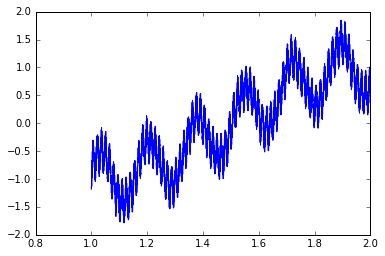

In [19]:
xvals = np.linspace(1,2,1e4)
a,b = .5, (2+3*Pi+.2)
yvals = [wfunc(xval,a,b,1e-12) for xval in xvals]
plt.plot(xvals,yvals)

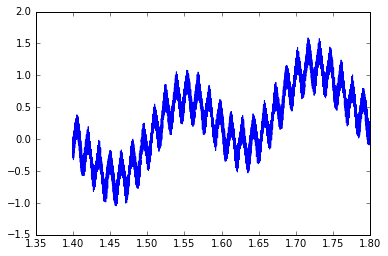

In [20]:
xvals = np.linspace(1.4,1.8,1e4)
a,b = .5, (2+3*Pi+.2)
yvals = [wfunc(xval,a,b,1e-12) for xval in xvals]
plt.plot(xvals,yvals)

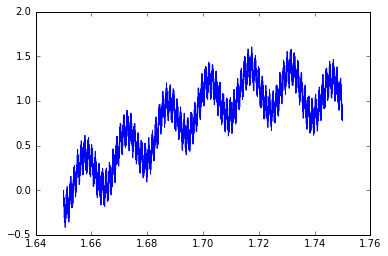

In [21]:
xvals = np.linspace(1.65,1.75,1e4)
a,b = .5, (2+3*Pi+.2)
yvals = [wfunc(xval,a,b,1e-12) for xval in xvals]
plt.plot(xvals,yvals)

In [73]:
def k_plot(P,Q,ptsx,ptsy,nlev):
    if nlev > 0:
        
        d = Q - P
        dperp = np.array([-d[1],d[0]])
        A = P + d/3.
        B = (P+Q)/2. + dperp/(2.*np.sqrt(3))
        C = P + 2.*d/3.
        
        indsx = [ii for ii,x in enumerate(ptsx) if x==Q[0]]
        indsy = [jj for jj,y in enumerate(ptsy) if y==Q[1]]
        
        if len(indsx)<len(indsy):
            mnln,mxln = len(indsx),len(indsy)
            sind,lind = indsx,indsy
        else:
            mnln,mxln = len(indsy),len(indsx)
            sind,lind = indsy,indsx
            
        for jj in range(mxln):
            for kk in range(mnln):
                if sind[kk]==lind[jj]:
                    ind = lind[jj]
                    break
        
        ptsx.insert(ind,C[0])
        ptsx.insert(ind,B[0])
        ptsx.insert(ind,A[0])
        
        ptsy.insert(ind,C[1])
        ptsy.insert(ind,B[1])
        ptsy.insert(ind,A[1])
        
        k_plot(P,A,ptsx,ptsy,nlev-1)
        k_plot(A,B,ptsx,ptsy,nlev-1)
        k_plot(B,C,ptsx,ptsy,nlev-1)
        k_plot(C,Q,ptsx,ptsy,nlev-1)    

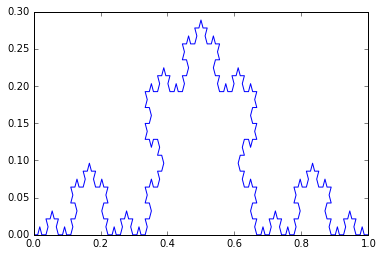

In [77]:
P = np.array([0.,0.])
Q = np.array([1.,0.])
ptsx = [0.,1.]
ptsy = [0.,0.]
k_plot(P,Q,ptsx,ptsy,4)
plt.plot(ptsx,ptsy)